### Imports

In [1]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import nltk
import re
from nltk.corpus import stopwords
from textblob import Word, TextBlob

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

### Load Dataset

In [2]:
train_df = pd.read_csv('train_data.csv')

### Data Preprocessing

In [3]:
train_df.drop(columns=['id','keyword','location'], axis=1, inplace=True)
print(train_df.shape)

(7613, 2)


In [4]:
train_df.head()

,text,target
0,Our Deeds are the Reason of this # earthquake...,1
1,Forest fire near La Ronge Sask . Canada,1
2,All residents asked to ' shelter in place ' ...,1
3,"13,000 people receive # wildfires evacuation ...",1
4,Just got sent this photo from Ruby # Alaska a...,1


In [5]:
train_df["text"]=train_df["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))
train_df["text"]=train_df["text"].str.replace('[^\w\s]', '').replace('\d', '')

sw=stopwords.words('english')
train_df["text"]=train_df["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
train_df["text"]=train_df["text"].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))

train_df.head()

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,13000 people receive wildfire evacuation order...,1
4,got sent photo ruby alaska smoke wildfire pour...,1


### Splitting Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text'],train_df['target'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6090,) (6090,) (1523,) (1523,)


### Tokenizing

In [7]:
vocab_size = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

tokenizer.fit_on_texts(X_train)

In [8]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [9]:
max_length = 120
trunc_type = 'post'
pad_type = 'post'

X_train_padded = pad_sequences(X_train, maxlen=max_length, truncating=trunc_type, padding=pad_type)
X_test_padded = pad_sequences(X_test, maxlen=max_length, truncating=trunc_type, padding=pad_type)

In [10]:
print(X_train_padded.shape, X_test_padded.shape)

(6090, 120) (1523, 120)


In [11]:
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))
y_train = np.array(y_train)
y_test = np.array(y_test)
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Model Creation

In [107]:
embedding_dim = 300

In [117]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(32, return_sequences=True))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [118]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 120, 300)          3000000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 120, 32)           42624     
_________________________________________________________________
flatten_10 (Flatten)         (None, 3840)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                122912    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 3,165,569
Trainable params: 3,165,569
Non-trainable params: 0
_________________________________________________________________


### Model Compilation

In [119]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(
    loss = "binary_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"]
)

In [120]:
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

In [121]:
ep = EarlyStopping(
    monitor='val_accuracy', 
    patience=7,
)

### Model Training

In [122]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
39/39 [==============================] - 4s 53ms/step - loss: 0.6867 - accuracy: 0.5482 - val_loss: 0.6826 - val_accuracy: 0.5599

Epoch 00001: val_accuracy improved from -inf to 0.55993, saving model to my_checkpoint.ckpt
Epoch 2/25
39/39 [==============================] - 2s 44ms/step - loss: 0.6752 - accuracy: 0.5811 - val_loss: 0.6718 - val_accuracy: 0.5599

Epoch 00002: val_accuracy did not improve from 0.55993
Epoch 3/25
39/39 [==============================] - 2s 43ms/step - loss: 0.6578 - accuracy: 0.5812 - val_loss: 0.6380 - val_accuracy: 0.6617

Epoch 00003: val_accuracy improved from 0.55993 to 0.66174, saving model to my_checkpoint.ckpt
Epoch 4/25
39/39 [==============================] - 2s 43ms/step - loss: 0.6077 - accuracy: 0.7127 - val_loss: 0.5558 - val_accuracy: 0.7603

Epoch 00004: val_accuracy improved from 0.66174 to 0.76026, saving model to my_checkpoint.ckpt
Epoch 5/25
39/39 [==============================] - 2s 43ms/step - loss: 0.4554 - accuracy: 0.8

### Graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


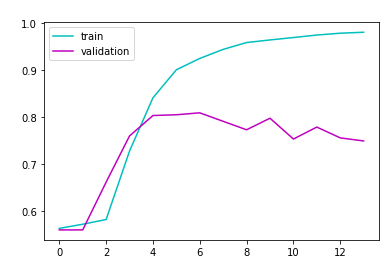

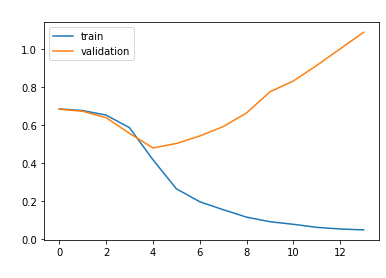

In [123]:
print(history.history.keys())
plt.axes().set(facecolor ="white")
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy').set_color('white')
plt.ylabel('accuracy').set_color('white')
plt.xlabel('epoch').set_color('white')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.axes().set(facecolor ="white")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model loss').set_color('white')
plt.ylabel('loss').set_color('white')
plt.xlabel('epoch').set_color('white')
plt.show()

### Model Evaluation

In [135]:
model.load_weights(filepath)

In [125]:
model.evaluate(X_test_padded, y_test)

48/48 [==============================] - 0s 4ms/step - loss: 0.5242 - accuracy: 0.8050


[0.5241948366165161, 0.8049901723861694]

### Model Saving

In [ ]:
model.save('./model/model_ver5.h5')

### Model Loading

In [ ]:
mymodel = tf.keras.models.load_model('./model/model_ver5.h5')

In [ ]:
mymodel.summary()

### Predicting Test Data

In [126]:
predictions = model.predict_classes(X_test_padded)

### Accuracy

In [127]:
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.8049901510177282


### Confusion Matrix

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.79691   0.88545   0.83885       873
           1    0.81917   0.69692   0.75312       650

    accuracy                        0.80499      1523
   macro avg    0.80804   0.79119   0.79598      1523
weighted avg    0.80641   0.80499   0.80226      1523



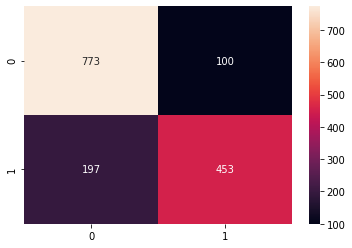

In [134]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

### Predicting new tweets

In [148]:
def preprocess_tweet(new_tweet):    
    new_tweet = new_tweet.lower()
    new_tweet = re.sub('[^\w\s]', '', new_tweet)
    new_tweet = re.sub('\d', '', new_tweet)

    new_tweet = " ".join(x for x in new_tweet.split() if x not in sw)
    new_tweet = " ".join([Word(word).lemmatize() for word in new_tweet.split()])
    print("AFTER PRE-PROCESSING:", new_tweet)
    
    tokenizer.fit_on_texts(new_tweet)

    new_tweet = tokenizer.texts_to_sequences([new_tweet])

    new_tweet =  pad_sequences(new_tweet, maxlen=max_length, truncating=trunc_type, padding=pad_type)

    return new_tweet

def predict_newTweet(tweet):
    print("Input Tweet: ", tweet)
    emb_tweet = preprocess_tweet(tweet)
    result = model.predict_classes(emb_tweet)
#     print(result)
    print("RESULT: " + "Real News" if result[0][0] == 1 else "Fake News")


In [151]:
new_tweet = "Fires start in apartment buildings in Chicago; injuring 20 civilians #CNN"
predict_newTweet(new_tweet)

Input Tweet:  Fires start in apartment buildings in Chicago; injuring 20 civilians #CNN
AFTER PRE-PROCESSING: fire start apartment building chicago injuring civilian cnn
RESULT: Real News


In [153]:
new_tweet = "hello this is a random tweet :)"
predict_newTweet(new_tweet)

Input Tweet:  hello this is a random tweet :)
AFTER PRE-PROCESSING: hello random tweet
Fake News
